In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.distributions.normal import Normal

from torch.utils.data import DataLoader
import torchvision.transforms as tt

from tqdm import tqdm_notebook as tqdm
import matplotlib

In [2]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)
    
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        
        #architecture of the network copied from the article
        self.seq = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
            Flatten()
        )
        self.clf = nn.Linear(in_features=4608, out_features=10, bias=True)
        
    def forward(self, x):
        return self.clf(self.seq(x)) 

In [3]:
#copied numbers from the article
N_EPOCHS = 300
Z_DIM = 2
STAT_STEP = 500
BATCH_SIZE = 32

device = 'cuda'
N_MODELS = 100

In [4]:
#read data
PATH = './models_notMNIST/model_'
weights_paths = []
learned_models = []

#load learned models
for i in range(N_MODELS):
    model = Conv_Net()
    weights_paths.append(PATH + str(i) + '.pt')
    
    model.load_state_dict(torch.load(weights_paths[i], map_location = 'cpu'))
    learned_models.append(model)

In [5]:
#perfrom seris of transformations to get weights as tensor of shape[256000x1x7x7]
weights = []
for model in learned_models:
    weights.append(model.seq)

weights[0][0].weight.size()
for i in range(len(weights)):
    weights[i] = weights[i][0].weight
    
new_weights = []
for i in range(len(weights)):
    for j in range(len(weights[i])):
        new_weights.append(weights[i][j])
        
print(new_weights[0].shape)

torch.Size([1, 7, 7])


In [6]:
#important moment: weights with larger norm make more sense 
#others only make training of vae more challenging
weights_norm = torch.FloatTensor([torch.norm(w[0]).detach() for w in new_weights])

values, inds = torch.topk(weights_norm, k=2000)

new_weights = np.array(new_weights)[inds]

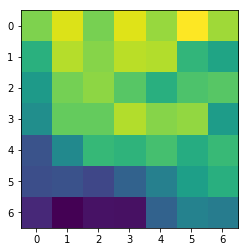

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(new_weights[10].detach().numpy().reshape((7, 7)))

In [8]:
train_loader = DataLoader(dataset=new_weights, batch_size=BATCH_SIZE, shuffle=True) 

In [9]:
class VAE(nn.Module):
    def __init__(self, D, d = Z_DIM):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, D)
        self.decoder = Decoder(d, D)
        
        #d - for latent space
        #D - for kernel space
        self.d = d
        self.D = D
        
    def count_vlb(self, X, i):
        #get parameters of z distribution
        mu_z, var_z = self.encoder(X)

        #sample latent(mu_z, var_z)
        z = Normal(torch.zeros(mu_z.size()), torch.ones(mu_z.size())).sample()
        z = mu_z + torch.sqrt(var_z) * nn.Parameter(z, requires_grad=False).to(device)
        
        latent_loss = 0.5 * (var_z + mu_z**2 - torch.log(var_z+1e-12) - 1).mean(dim=0).sum()
        
        #get parameters of x_hat distribution
        mu_x, var_x = self.decoder(z)
        normal = Normal(mu_x, torch.sqrt(var_x))
        reconstruction_loss = normal.log_prob(X).mean(dim=0).sum()
        
        #minus since default optimizers minimize loss
        return -(reconstruction_loss - latent_loss), latent_loss, reconstruction_loss
                   
    def generate_samples(self, num_samples):
        z = torch.FloatTensor(np.random.normal(0, 1, size=[num_samples, self.d, 1, 1])).to(device)
        return self.decoder(z)

In [10]:
class Encoder(nn.Module):
    def __init__(self, d, D):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        
        self.fc_mu = nn.Conv2d(64, Z_DIM, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [11]:
class Decoder(nn.Module):
    def __init__(self, d, D):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        self.fc_mu = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [12]:
#Adam optimizer !without! linear learning rate decay from 1e-3 to 0.
vae = VAE(49).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

from IPython.display import clear_output

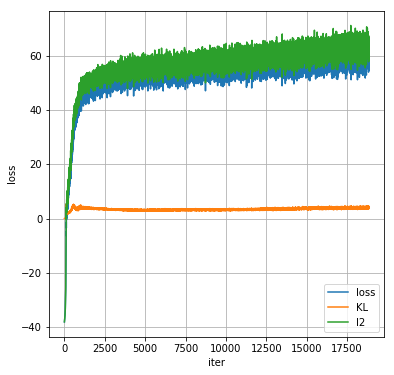

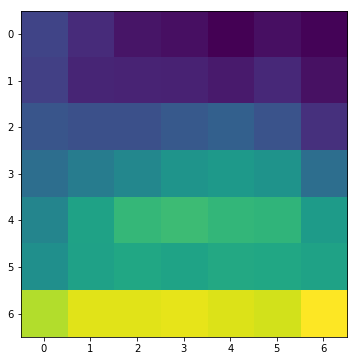

<Figure size 432x288 with 0 Axes>

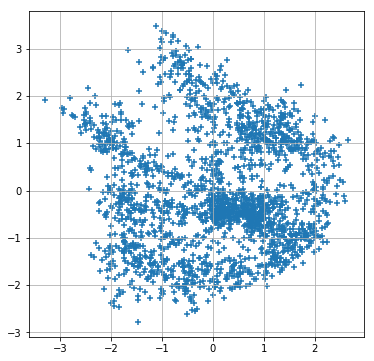

In [13]:
loss_list = []
kl_loss_list = []
l2_loss_list = []
N_STEPS = len(train_loader)

#train network
for j in range(N_EPOCHS):
    for k, images in enumerate(train_loader):
        #forward
        images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
        images = images.to(device)
        vlb, kl, l2 = vae.count_vlb(images, j*N_EPOCHS + k)

        #backward
        optimizer.zero_grad()
        vlb.backward()
        optimizer.step()

        loss_list.append(-vlb.item())
        kl_loss_list.append(kl)
        l2_loss_list.append(l2)
        
        if k % STAT_STEP == 0:
            print('Epoch {}/{}, Step {}/{}, Loss: {}'
                  .format(j, N_EPOCHS, k, N_STEPS, vlb.item()))
            clear_output()
            plt.figure(figsize=(6, 6))
            
            #plot statistics of loss
            plt.plot([i for i in range(len(loss_list))], loss_list, label = 'loss')
            plt.plot([i for i in range(len(loss_list))], kl_loss_list, label = 'KL')
            plt.plot([i for i in range(len(loss_list))], l2_loss_list, label = 'l2')

            plt.xlabel('iter')
            plt.ylabel('loss')
            plt.legend()
            plt.grid()
            
            #plot example of generated weight
            plt.figure(figsize=(6, 6))
            with torch.no_grad():
                mu_x, _ = vae.generate_samples(1)
                mu_x = mu_x.detach().cpu().numpy()
                plt.imshow(mu_x[0].reshape((7, 7)))
                
            plt.figure()
            mu_list = []
            
            #plot latent space
            plt.figure(figsize=(6, 6))
            with torch.no_grad():
                for k, images in enumerate(train_loader):
                    images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
                    images = images.to(device)

                    mu, var  = vae.encoder(images)
                    mu = mu.cpu().numpy()
                    mu_list.append(mu)

            mu = np.concatenate(mu_list)
            mu = np.squeeze(mu, axis = 2)
            mu = np.squeeze(mu, axis = 2)
            plt.scatter(mu[:, 0], mu[:, 1], marker = '+')
            plt.grid()

            plt.show()

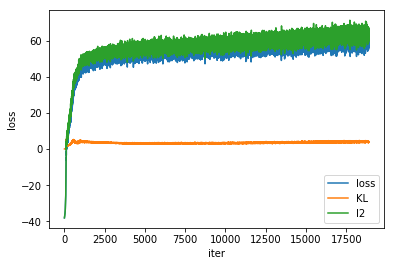

In [14]:
#final plot of losses
plt.figure()
plt.plot([i for i in range(len(loss_list))], loss_list, label = 'loss')
plt.plot([i for i in range(len(loss_list))], kl_loss_list, label = 'KL')
plt.plot([i for i in range(len(loss_list))], l2_loss_list, label = 'l2')

plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.show()

In [15]:
torch.save(vae.state_dict(), "vae_weights.pth")

[ 2.2445369 -1.903023   0.2071716 ... -0.5618707  0.3116336  1.5147945]


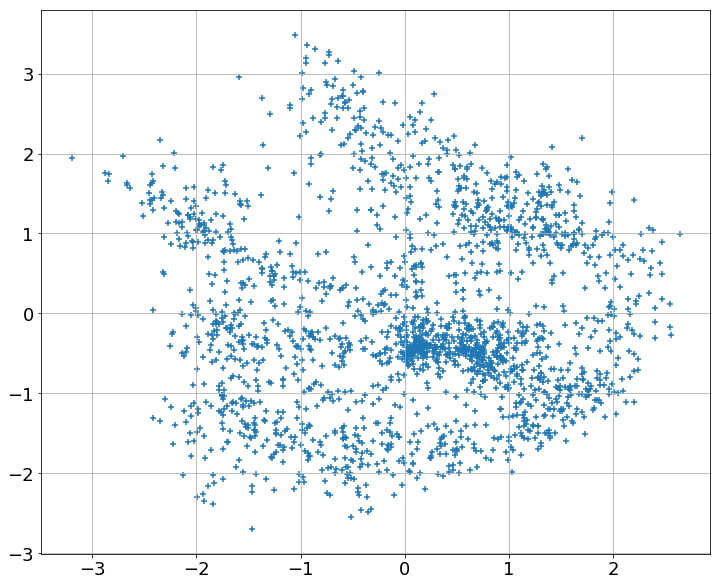

In [16]:
# vae.load_state_dict(torch.load("vae_weights.pth"))

#plot latent space
mu_list = []

with torch.no_grad():
    for k, images in enumerate(train_loader):
        images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
        images = images.to(device)
        
        mu, var  = vae.encoder(images)
        mu = mu.cpu().numpy()
        mu_list.append(mu)

mu = np.concatenate(mu_list)
mu = np.squeeze(mu, axis = 2)
mu = np.squeeze(mu, axis = 2)

print(mu[:, 0])

plt.figure(figsize=(12, 10))
matplotlib.rcParams.update({'font.size': 18})

plt.scatter(mu[:, 0], mu[:, 1], marker = '+')

plt.grid()

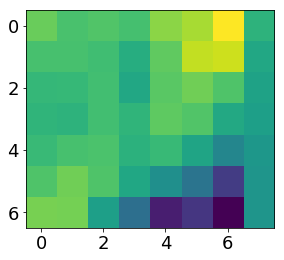

In [17]:
#generate exapmles of weigths
with torch.no_grad():
    mu_x, _ = vae.generate_samples(100)
    mu_x = mu_x.detach().cpu().numpy()
    
#show weight coresponding to the point (x, y) in latent space
x = -2.5
y = -0.5
plt.imshow(vae.decoder(torch.cuda.FloatTensor([1, 1, x, y]).view([1, 2, 1, -1]))[0].cpu().reshape((7, 8)).detach().numpy())